In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os


Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('/Users/macintosh/Desktop/Dissertation/EDA/Model_data')

In [3]:
df

,Order ID,Order Item ID,Order YearMonth,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,...,Lead Time,Holding Cost,Ordering Cost,Holding Rate,Restock Now,Daily Demand Std Dev,Safety Stock,Season,Season Encoded,Shipment Mode Encoded
0,1,4381,202101,1,2:48,1,Fan Shop,Water Sports,Pelican Sunstream 100 Kayak,7399,...,3.034689,0.321810,50,0.2,0,1.510322,4.341208,Winter,0,0
1,2,29,202101,1,3:30,1,Apparel,Cleats,Perfect Fitness Perfect Rip Deck,918,...,3.063141,0.139034,50,0.2,0,1.510322,4.361511,Winter,0,3
2,3,32,202101,1,3:30,4,Footwear,Cardio Equipment,Nike Men's Free 5.0+ Running Shoe,918,...,3.071025,0.252642,50,0.2,1,1.510322,4.367121,Winter,0,3
3,4,33,202101,1,3:30,5,Fan Shop,Indoor/Outdoor Games,O'Brien Men's Neoprene Life Vest,918,...,3.098653,0.400460,50,0.2,0,1.510322,4.386721,Winter,0,3
4,5,109801,202101,1,4:12,5,Footwear,Electronics,Under Armour Women's Ignite Slide,6124,...,2.928571,0.201618,50,0.2,0,1.510322,4.264630,Winter,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30866,30867,69831,202312,31,3:53,1,Outdoors,Accessories,Team Golf Texas Longhorns Putter Grip,701,...,2.912281,0.449210,50,0.2,0,0.000000,0.000000,Winter,0,2
30867,30868,73992,202312,31,4:56,1,Footwear,Cardio Equipment,Nike Men's Free 5.0+ Running Shoe,8837,...,3.071025,0.252642,50,0.2,1,0.000000,0.000000,Winter,0,2
30868,30869,178348,202312,31,7:03,1,Discs Shop,DVDs,DVDs,18586,...,3.090164,0.407106,50,0.2,0,0.000000,0.000000,Winter,0,2
30869,30870,180390,202312,31,13:21,1,Apparel,Women's Clothing,Summer dresses,20628,...,2.884058,0.272500,50,0.2,0,0.000000,0.000000,Winter,0,3


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.isnull().sum()

Order ID                     0
Order Item ID                0
Order YearMonth              0
Order Day                    0
Order Time                   0
Order Quantity               0
Product Department           0
Product Category             0
Product Name                 0
Customer ID                  0
Customer Market              0
Customer Region              0
Customer Country             0
Warehouse Country            0
Shipment Day                 0
Shipment Mode                0
Shipment Days - Scheduled    0
Gross Sales                  0
Discount %                   0
Profit                       0
date                         0
Year Month                   0
Warehouse Inventory          0
Inventory Cost Per Unit      0
Stockout                     0
Inventory Value              0
Profit Margin                0
Inventory Cost               0
Inventory Efficiency         0
Fulfillment Lag (days)       0
EOQ                          0
Reorder Point                0
Lead Tim

In [6]:
sales_by_week_category = df.copy()

sales_by_week_category['date'] = sales_by_week_category['date'].astype('datetime64[ns]')

sales_by_week_category['date'] = sales_by_week_category['date'].dt.to_period('W')

sales_by_week_category = sales_by_week_category.groupby(['date', 'Product Department']).sum()['Gross Sales'].reset_index()

sales_by_week_category['date'] = sales_by_week_category['date'].dt.to_timestamp()

sales_by_week_category.head(10)

,date,Product Department,Gross Sales
0,2020-12-28,Apparel,40880
1,2020-12-28,Fan Shop,97420
2,2020-12-28,Fitness,1035
3,2020-12-28,Footwear,26107
4,2020-12-28,Golf,24800
5,2020-12-28,Outdoors,4550
6,2021-02-01,Apparel,35680
7,2021-02-01,Fan Shop,90440
8,2021-02-01,Fitness,967
9,2021-02-01,Footwear,21675


In [7]:
train_data_week = {}
test_data_week = {}

for category in sales_by_week_category['Product Department'].unique():
    category_data_weekly = sales_by_week_category[sales_by_week_category['Product Department'] == category][['date', 'Gross Sales']]
    
    category_data_weekly = category_data_weekly.rename(columns = {'date': 'ds', 'Gross Sales': 'y'})
    
    train_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year < 2023]
    test_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year >= 2023]

In [8]:
train_data_week

{'Apparel':             ds      y
 0   2020-12-28  40880
 6   2021-02-01  35680
 12  2021-03-01  40430
 18  2021-03-29  40690
 24  2021-04-26  33320
 30  2021-05-31  36690
 36  2021-06-28  40071
 43  2021-07-26  39600
 52  2021-08-30  33139
 61  2021-09-27  35883
 69  2021-11-01  37950
 76  2021-11-29  32546
 83  2021-12-27  42180
 91  2022-01-31  33892
 99  2022-02-28  44690
 107 2022-03-28  40250
 113 2022-04-25  44380
 119 2022-05-30  40590
 125 2022-06-27  40120
 131 2022-08-01  46706
 137 2022-08-29  36680
 144 2022-09-26  43950
 150 2022-10-31  38120
 156 2022-11-28  41210
 163 2022-12-26  35980,
 'Fan Shop':             ds       y
 1   2020-12-28   97420
 7   2021-02-01   90440
 13  2021-03-01   86710
 19  2021-03-29   90880
 25  2021-04-26   78050
 31  2021-05-31   88365
 37  2021-06-28   82370
 46  2021-07-26   89490
 55  2021-08-30   88620
 63  2021-09-27   89400
 71  2021-11-01   81660
 78  2021-11-29   91400
 85  2021-12-27   97850
 93  2022-01-31   84200
 101 2022-02-28   

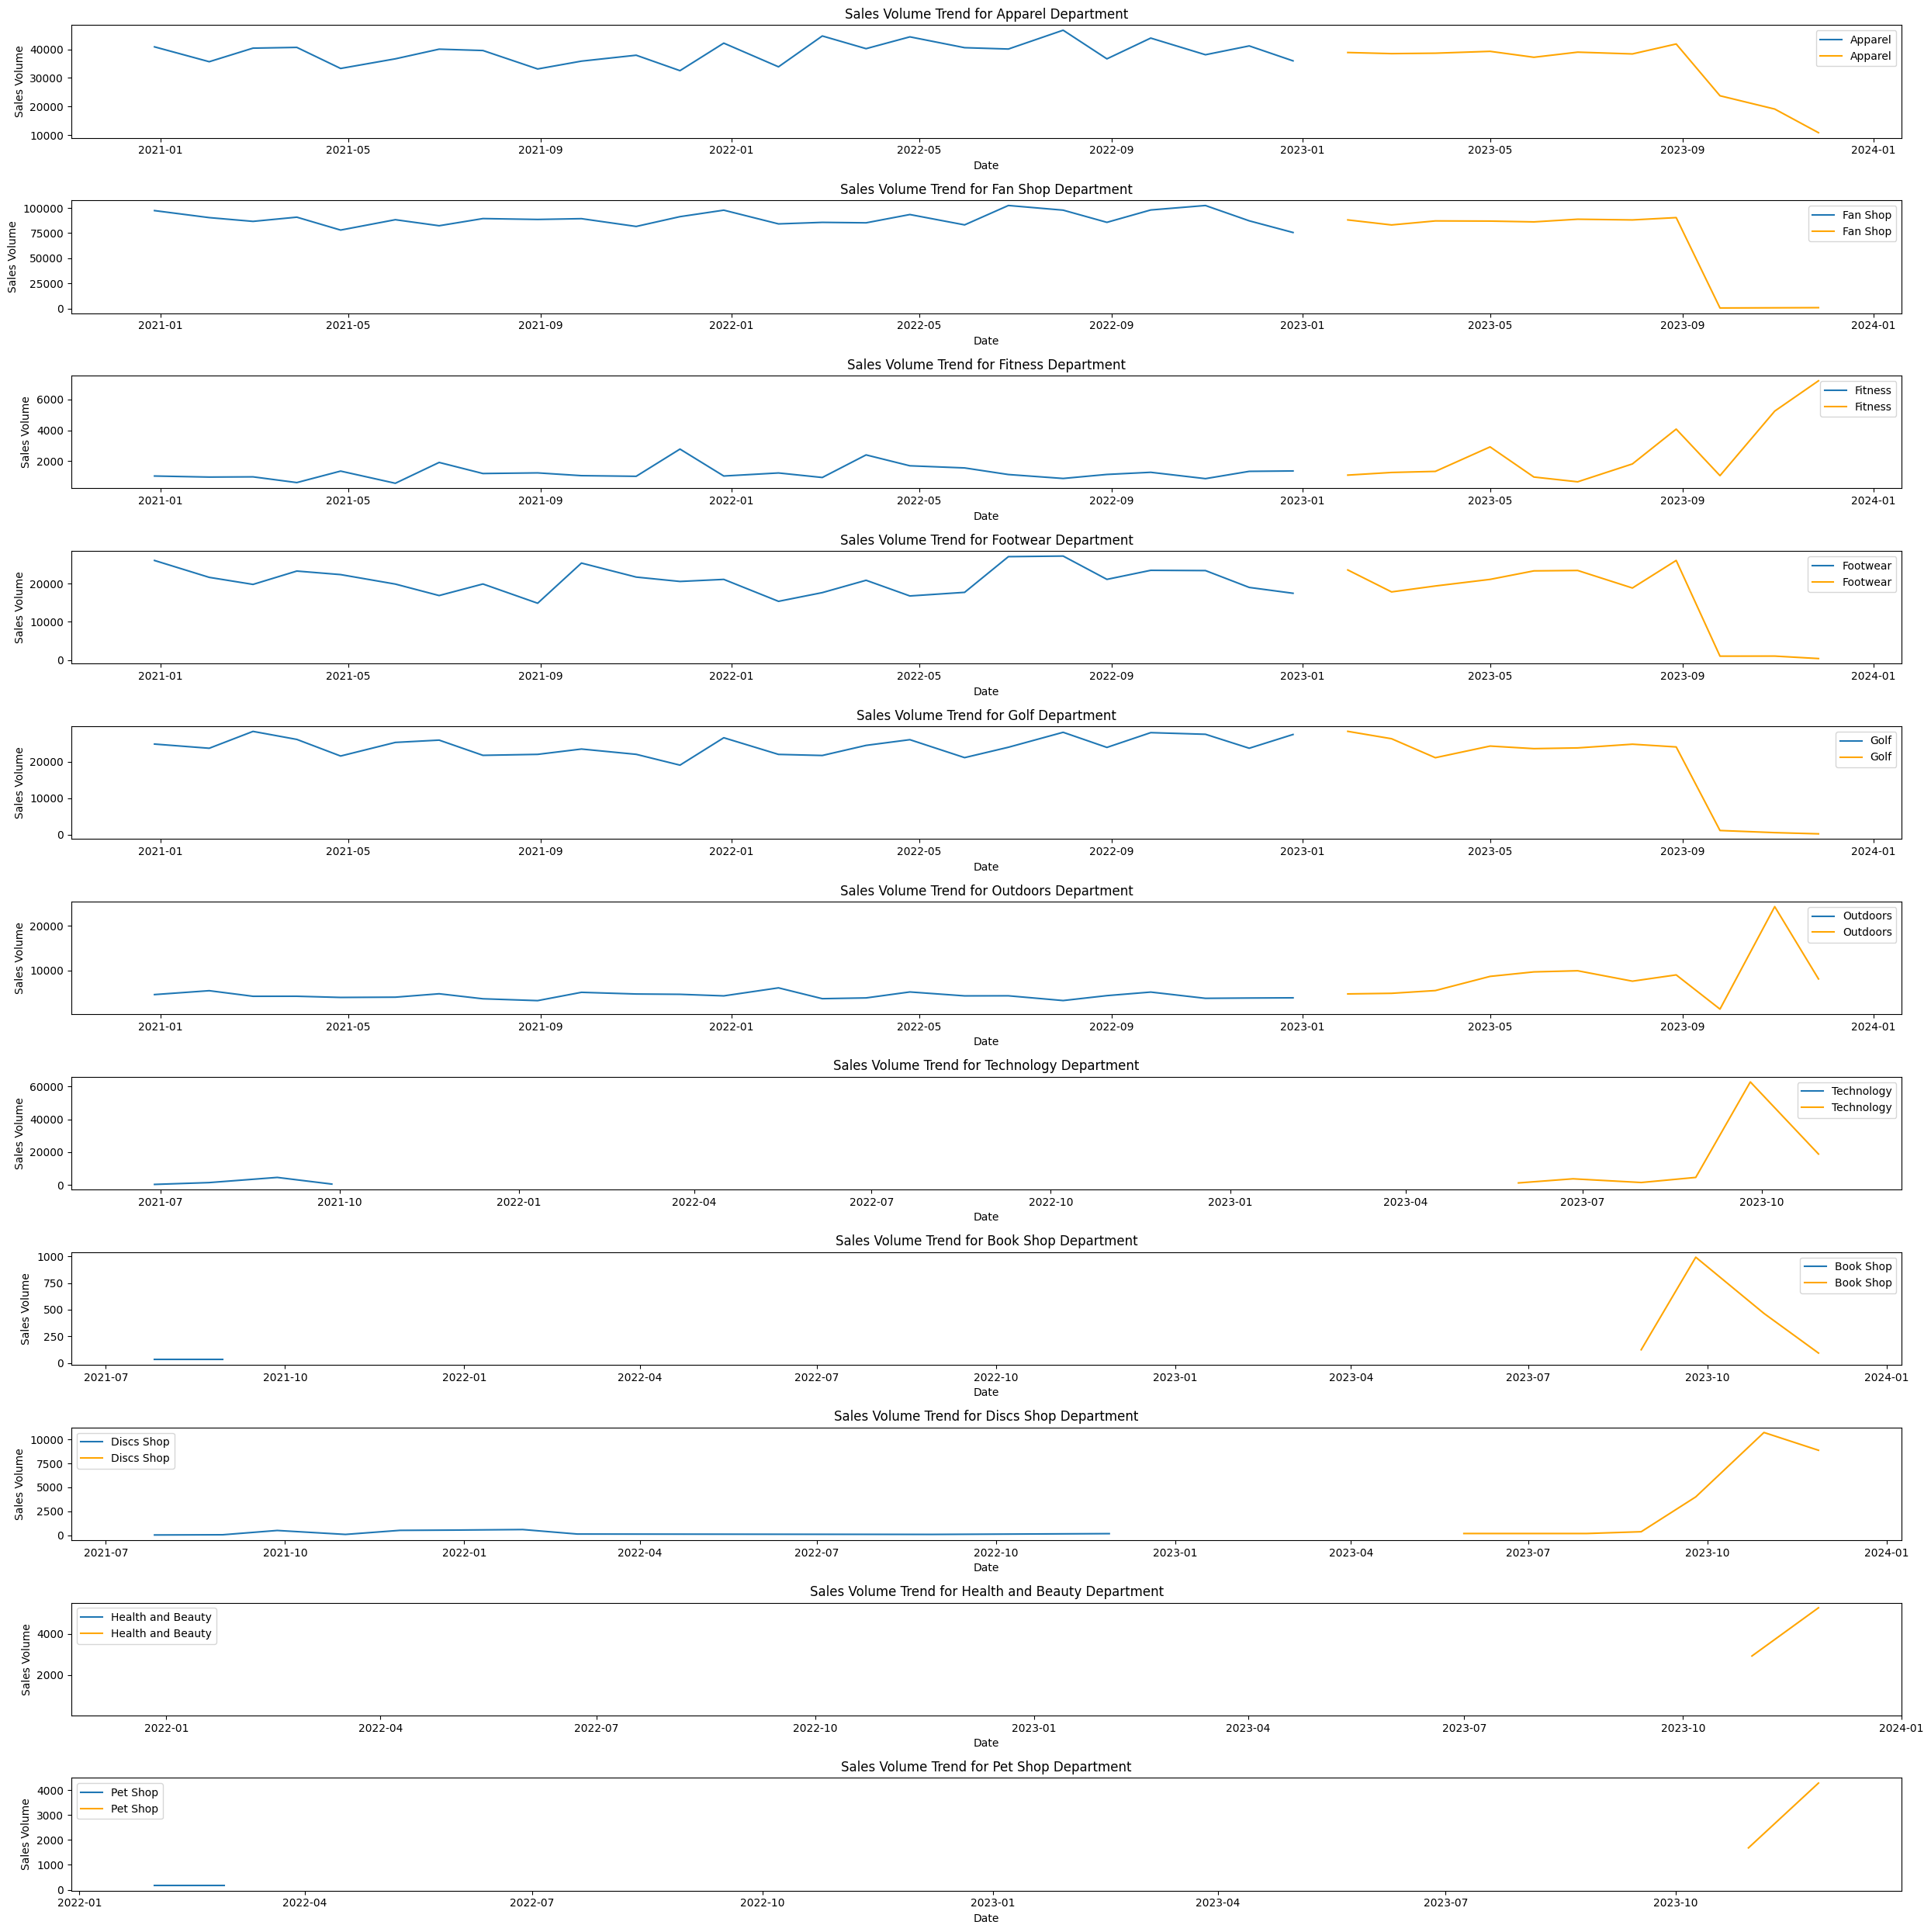

In [11]:
plt.figure(figsize=(25, 25))

for i in range(11): 
    category = sales_by_week_category['Product Department'].unique()[i]
    
    plt.subplot(11, 1, i+1)
    plt.plot(train_data_week[category]['ds'], train_data_week[category]['y'], label=category)
    plt.plot(test_data_week[category]['ds'], test_data_week[category]['y'], label=category, color = 'orange')
    plt.title(f'Sales Volume Trend for {category} Department')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    
plt.show()

In [13]:
prophet_weekly_model = {}

for category in sales_by_week_category['Product Department'].unique():
    df_train = train_data_week[category]

    # Drop rows where 'y' or 'ds' is missing
    df_train = df_train.dropna(subset=['ds', 'y'])

    if df_train.shape[0] < 2:
        print(f"Skipping {category}: not enough data")
        continue  # skip this category

    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True
    )

    model.fit(df_train)
    prophet_weekly_model[category] = model

15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing
15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing
15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing
15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing
15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing
15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:47 - cmdstanpy - INFO - Chain [1] done processing


Skipping Health and Beauty: not enough data


In [14]:
prophet_weekly_model

{'Apparel': <prophet.forecaster.Prophet at 0x11aae92b0>,
 'Fan Shop': <prophet.forecaster.Prophet at 0x11ac28230>,
 'Fitness': <prophet.forecaster.Prophet at 0x11aae9520>,
 'Footwear': <prophet.forecaster.Prophet at 0x11c53f4a0>,
 'Golf': <prophet.forecaster.Prophet at 0x11c300d10>,
 'Outdoors': <prophet.forecaster.Prophet at 0x11ac30cb0>,
 'Technology': <prophet.forecaster.Prophet at 0x11abf8e30>,
 'Book Shop': <prophet.forecaster.Prophet at 0x11ac25130>,
 'Discs Shop': <prophet.forecaster.Prophet at 0x11ae62660>,
 'Pet Shop': <prophet.forecaster.Prophet at 0x11ac29ee0>}

/var/folders/x2/xzn0478s38vfcsjrc5rzqfyr0000gn/T/ipykernel_21960/593504059.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/x2/xzn0478s38vfcsjrc5rzqfyr0000gn/T/ipykernel_21960/593504059.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/x2/xzn0478s38vfcsjrc5rzqfyr0000gn/T/ipykernel_21960/593504059.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/x2/xzn0478s38vfcsjrc5rzqfyr0000gn/T/ipykernel_21960/593504059.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/x2/xzn0478s38vfcsjrc5rzqfyr0000gn/T/ipykernel_21960/593504059.py:13: Us

KeyError: 'Health and Beauty'

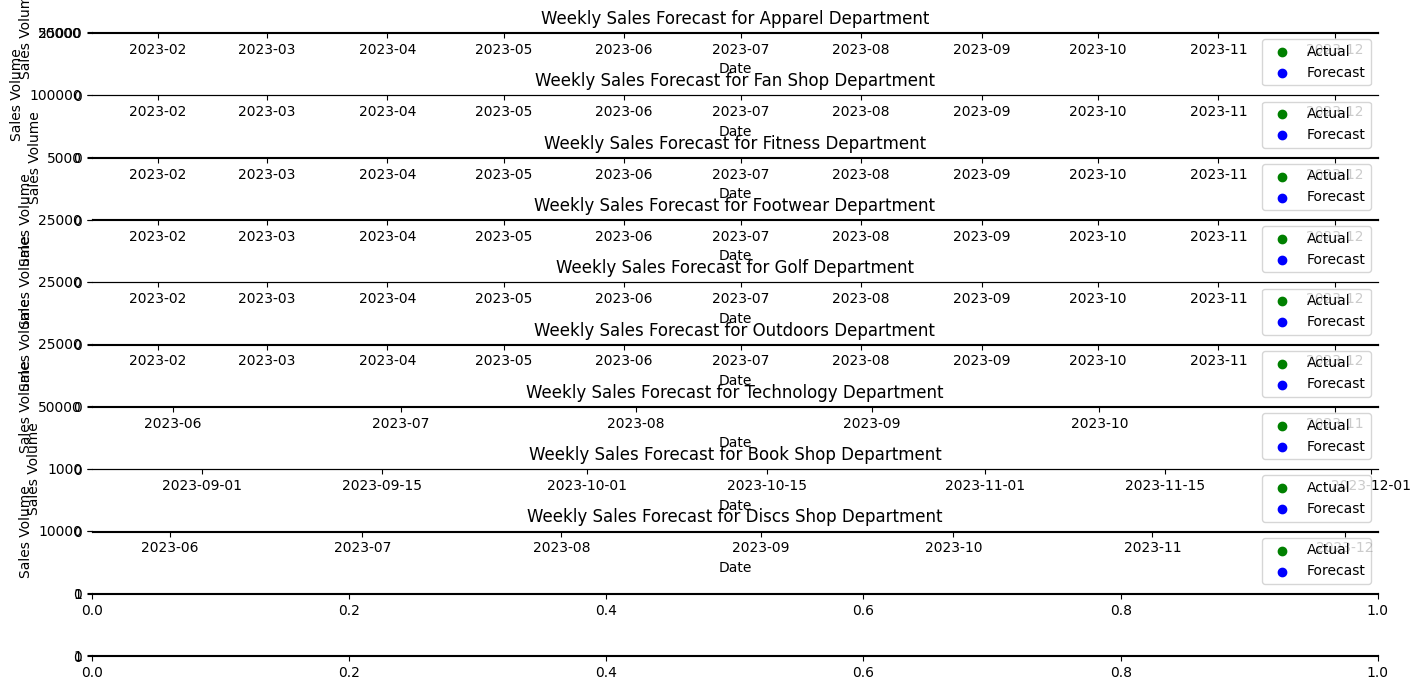

In [16]:
prophet_week_forecast = {}

fig, ax = plt.subplots(11, 1, figsize=(14, 7))

for i in range(11):
    category = sales_by_week_category['Product Department'].unique()[i]
    
    prophet_week_forecast[category] = prophet_weekly_model[category].predict(test_data_week[category])
   
    ax[i].scatter(test_data_week[category]['ds'], test_data_week[category]['y'], label = 'Actual', color='green')
    ax[i].scatter(prophet_week_forecast[category]['ds'], prophet_week_forecast[category]['yhat'], label = 'Forecast', color='blue')
    
    plt.tight_layout()
    ax[i].set_title(f'Weekly Sales Forecast for {category} Department')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')
    ax[i].legend()
plt.show()

In [23]:
for category, df in train_data_week.items():
    print(f"{category}: {df.shape[0]} rows")
    

Accessories: 25 rows
Baseball & Softball: 25 rows
Boxing & MMA: 21 rows
Camping & Hiking: 25 rows
Cardio Equipment: 25 rows
Cleats: 25 rows
Electronics: 25 rows
Fishing: 25 rows
Fitness Accessories: 21 rows
Girls' Apparel: 25 rows
Golf Apparel: 18 rows
Golf Balls: 25 rows
Golf Gloves: 25 rows
Golf Shoes: 23 rows
Hockey: 23 rows
Hunting & Shooting: 22 rows
Indoor/Outdoor Games: 25 rows
Kids' Golf Clubs: 4 rows
Lacrosse: 18 rows
Men's Footwear: 25 rows
Men's Golf Clubs: 4 rows
Shop By Sport: 25 rows
Tennis & Racquet: 20 rows
Trade-In: 25 rows
Water Sports: 25 rows
Women's Apparel: 25 rows
Women's Golf Clubs: 4 rows
Strength Training: 2 rows
Consumer Electronics: 1 rows
Crafts: 3 rows
Baby: 2 rows
Books: 2 rows
CDs: 2 rows
Cameras: 3 rows
Soccer: 2 rows
DVDs: 4 rows
Garden: 4 rows
Video Games: 6 rows
Music: 2 rows
Sporting Goods: 4 rows
Women's Clothing: 3 rows
Health and Beauty: 1 rows
Pet Supplies: 2 rows
Golf Bags & Carts: 0 rows
As Seen on  TV!: 0 rows
Basketball: 0 rows
Children's Cl